<a href="https://colab.research.google.com/github/chocojini/saessag_project1/blob/main/%5B230320%5Dproject1_Health_Insureance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# !pip install imbalanced-learn
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf #폰트 다운로드 한 후 런타임 다시시작!!!!
# !pip install catboost

In [74]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

#한글폰트 나오게
plt.rc('font', family='NanumBarunGothic')
import matplotlib as mpl #음수 표기되게
mpl.rc('axes', unicode_minus=False)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [75]:
df = pd.read_csv('/content/train.csv')
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


# Encoding

Gender, Vehicle_Age, Vehicle_Damage => 인코딩

Region_Code, Annual_Premium, Policy_Sales_Channel => float-> int


In [76]:
encoder = LabelEncoder()
encoder.fit(df['Gender'])
df['Gender_Label_En'] = encoder.transform(df['Gender'])
df['Region_Code_re'] = df['Region_Code'].astype(int)
encoder.fit(df['Vehicle_Age'])
df['Vehicle_Age_Label_En'] = encoder.transform(df['Vehicle_Age'])
encoder.fit(df['Vehicle_Damage'])
df['Vehicle_Damage_Label_En'] = encoder.transform(df['Vehicle_Damage'])
df['Annual_Premium_re'] = df['Annual_Premium'].astype(int)
df['Policy_Sales_Channel_re'] = df['Policy_Sales_Channel'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       381109 non-null  int64  
 1   Gender                   381109 non-null  object 
 2   Age                      381109 non-null  int64  
 3   Driving_License          381109 non-null  int64  
 4   Region_Code              381109 non-null  float64
 5   Previously_Insured       381109 non-null  int64  
 6   Vehicle_Age              381109 non-null  object 
 7   Vehicle_Damage           381109 non-null  object 
 8   Annual_Premium           381109 non-null  float64
 9   Policy_Sales_Channel     381109 non-null  float64
 10  Vintage                  381109 non-null  int64  
 11  Response                 381109 non-null  int64  
 12  Gender_Label_En          381109 non-null  int64  
 13  Region_Code_re           381109 non-null  int64  
 14  Vehi

In [77]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Label_En,Region_Code_re,Vehicle_Age_Label_En,Vehicle_Damage_Label_En,Annual_Premium_re,Policy_Sales_Channel_re
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,1,28,2,1,40454,26
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,1,3,0,0,33536,26
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,1,28,2,1,38294,26
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,1,11,1,0,28619,152
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,0,41,1,0,27496,152


In [78]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'Gender_Label_En',
       'Region_Code_re', 'Vehicle_Age_Label_En', 'Vehicle_Damage_Label_En',
       'Annual_Premium_re', 'Policy_Sales_Channel_re'],
      dtype='object')

In [79]:
X_data = df[['Gender_Label_En', 'Driving_License', 'Region_Code_re',
       'Previously_Insured', 'Vehicle_Age_Label_En', 'Vehicle_Damage_Label_En', 'Annual_Premium_re',
       'Policy_Sales_Channel_re', 'Vintage']]
y = df['Response']

In [80]:
X_data.shape, y.shape

((381109, 9), (381109,))

# Feature Engineering Age_GP_s
Age는 20대, 30대, 40대, 그이상 으로 범주화

## age 범주화

Age_GP_q  = 사분위로 나눔

Age_GP_s  = 연령대로 나눔


In [81]:
# X_data['Age_GP_q'] = np.where (df['Age'] < 25, 1,
#                            np.where(df['Age'] < 36, 2,
#                            np.where(df['Age'] < 49, 3, 4)))
# X_data.Age_GP_q.value_counts(), sorted(X_data.Age_GP_q.unique()), len(X_data.Age_GP_q.unique())

In [82]:
# sns.countplot(x=y, hue=X_data['Age_GP_q'], data=X_data, dodge=True, palette="pastel");
# plt.legend(labels = ['25미만', '36미만', '49미만', '49이상']);

In [83]:
X_data['Age_GP_s'] = np.where (df['Age'] < 30, 1,
                           np.where(df['Age'] < 40, 2,
                           np.where(df['Age'] < 50, 3, 4)))
X_data.Age_GP_s.value_counts(), sorted(X_data.Age_GP_s.unique()), len(X_data.Age_GP_s.unique())

(1    155203
 4     94807
 3     76846
 2     54253
 Name: Age_GP_s, dtype: int64,
 [1, 2, 3, 4],
 4)

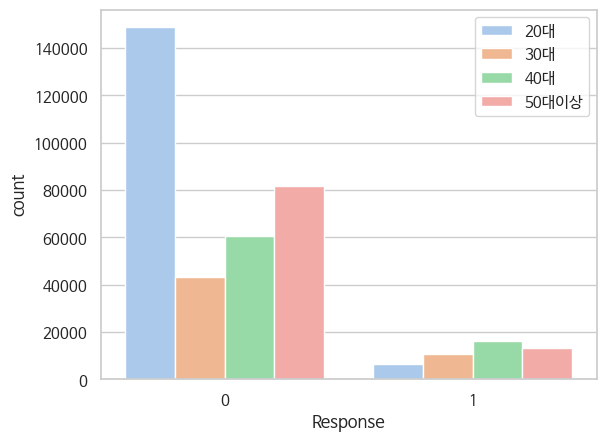

In [84]:
sns.countplot(x=y, hue=X_data['Age_GP_s'], data=X_data, dodge=True, palette="pastel");
plt.legend(labels = ['20대', '30대', '40대', '50대이상']);

### Age + Previously_Insured

In [85]:
X_data['age_PI'] = np.where ((X_data['Age_GP_s'] == 1) & (X_data['Previously_Insured'] == 0), 1,
                           np.where((X_data['Age_GP_s'] == 2) & (X_data['Previously_Insured'] == 0), 2,
                           np.where((X_data['Age_GP_s'] == 3) & (X_data['Previously_Insured'] == 0), 3,
                           np.where((X_data['Age_GP_s'] == 4) & (X_data['Previously_Insured'] == 0), 4, 5))))

X_data['age_PI'].value_counts()

5    174628
4     63595
3     55887
1     53124
2     33875
Name: age_PI, dtype: int64

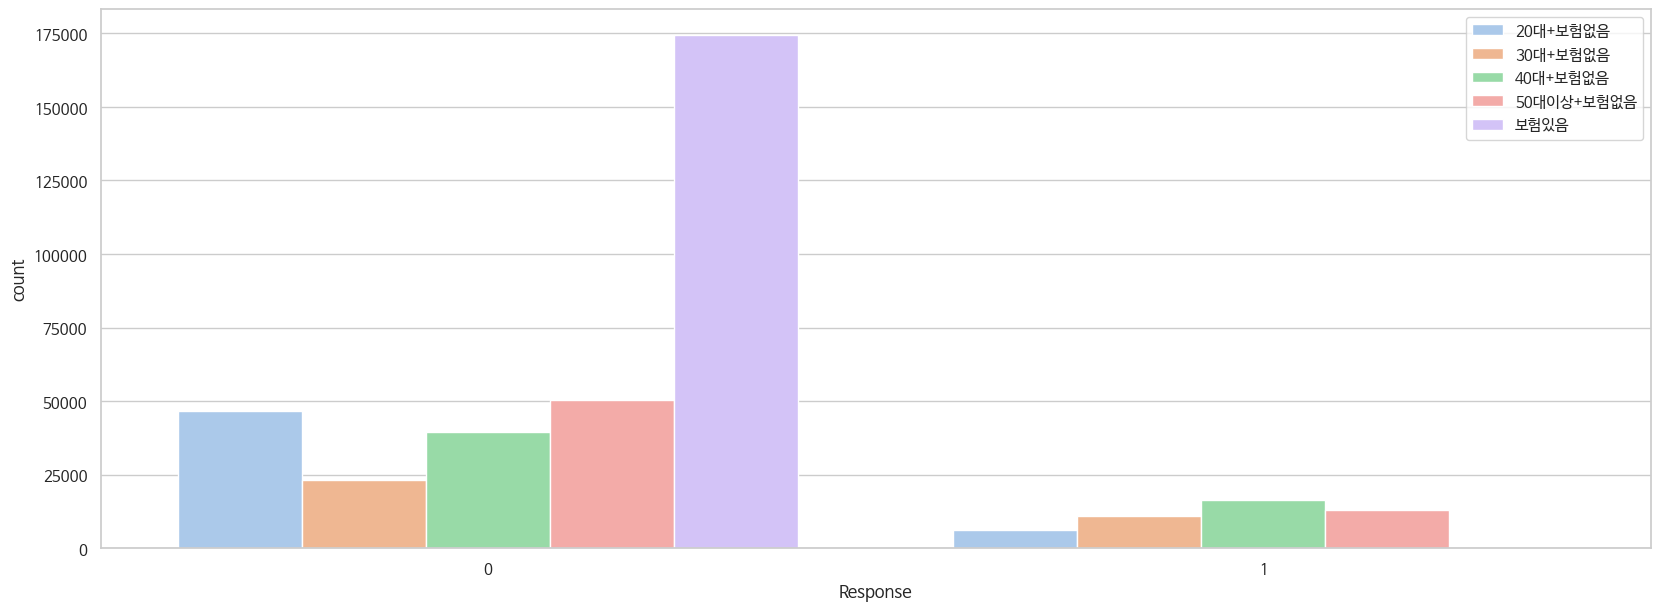

In [86]:
# response 0 = 관심x
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['age_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['20대+보험없음', '30대+보험없음', '40대+보험없음', '50대이상+보험없음', '보험있음']);

### Age + Vehicle_Damage

In [87]:
# Vehicle_Damage_Label_En = 0 -> 사고 o
X_data['age_VD'] = np.where ((X_data['Age_GP_s'] == 1) & (X_data['Vehicle_Damage_Label_En'] == 1), 1,
                           np.where((X_data['Age_GP_s'] == 2) & (X_data['Vehicle_Damage_Label_En'] == 1), 2,
                           np.where((X_data['Age_GP_s'] == 3) & (X_data['Vehicle_Damage_Label_En'] == 1), 3,
                           np.where((X_data['Age_GP_s'] == 4) & (X_data['Vehicle_Damage_Label_En'] == 1), 4, 5))))

X_data['age_VD'].value_counts()

5    188696
4     61383
3     52856
1     46743
2     31431
Name: age_VD, dtype: int64

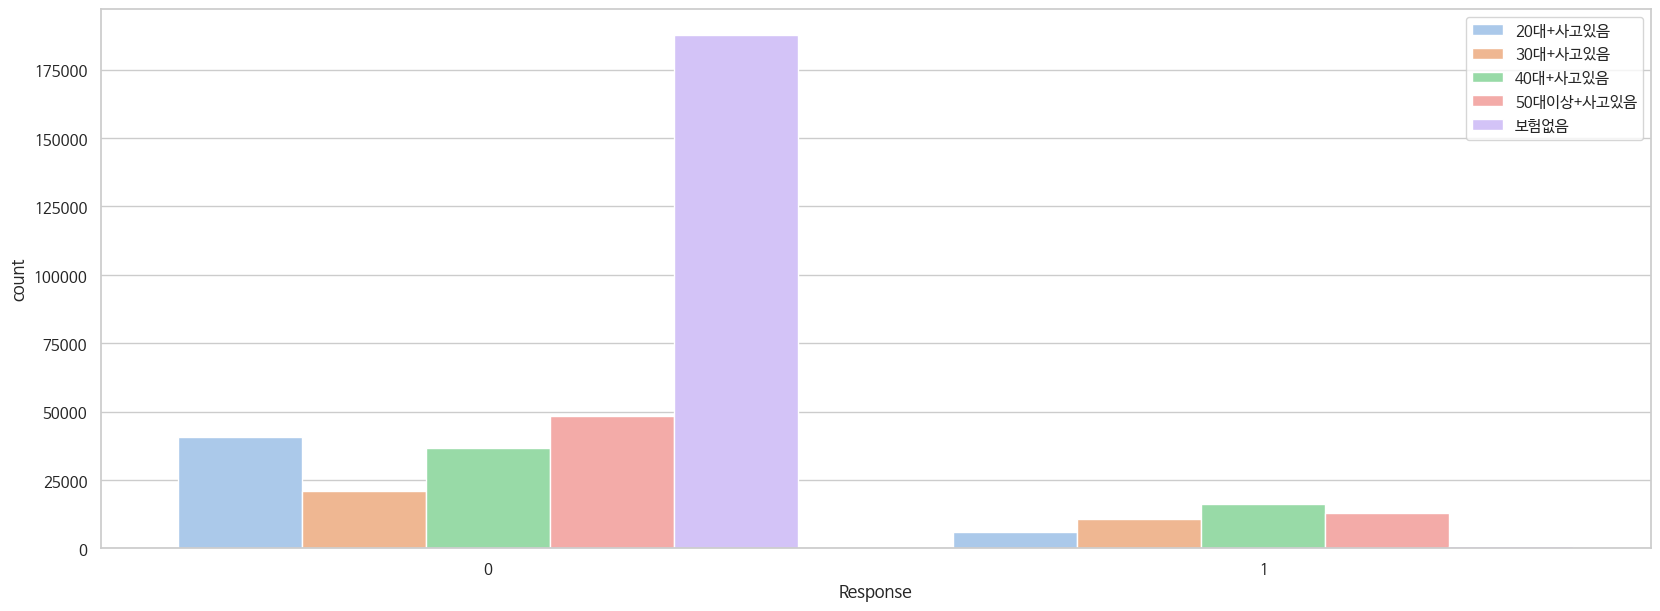

In [88]:
# response 0 = 관심x
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['age_VD'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['20대+사고있음', '30대+사고있음', '40대+사고있음', '50대이상+사고있음', '보험없음']);

## Vehicle_Age + PI

In [89]:
# Previously_Insured 이전 보험 0 가입 안됨 / 1 가입 됨 이고 1은 거의 response 1 이기에  하나로 통합
X_data['VA_PI'] = np.where ((X_data['Vehicle_Age_Label_En'] == 0) & (X_data['Previously_Insured'] == 0), 1,
                           np.where((X_data['Vehicle_Age_Label_En'] == 1) & (X_data['Previously_Insured'] == 0), 2,
                           np.where((X_data['Vehicle_Age_Label_En'] == 2) & (X_data['Previously_Insured'] == 0), 3,4)))

X_data['VA_PI'].value_counts()

4    174628
1    134991
2     55529
3     15961
Name: VA_PI, dtype: int64

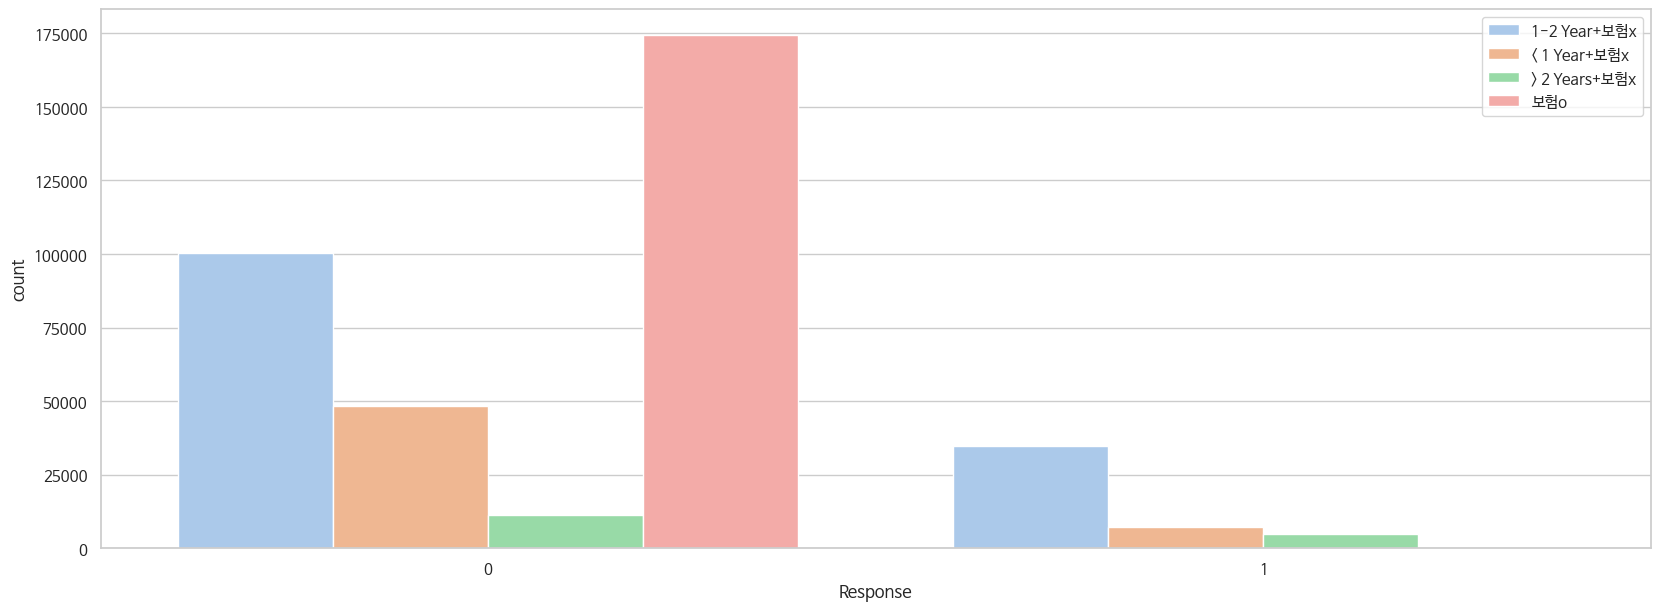

In [90]:
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['VA_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['1-2 Year+보험x', '< 1 Year+보험x', '> 2 Years+보험x', '보험o']);

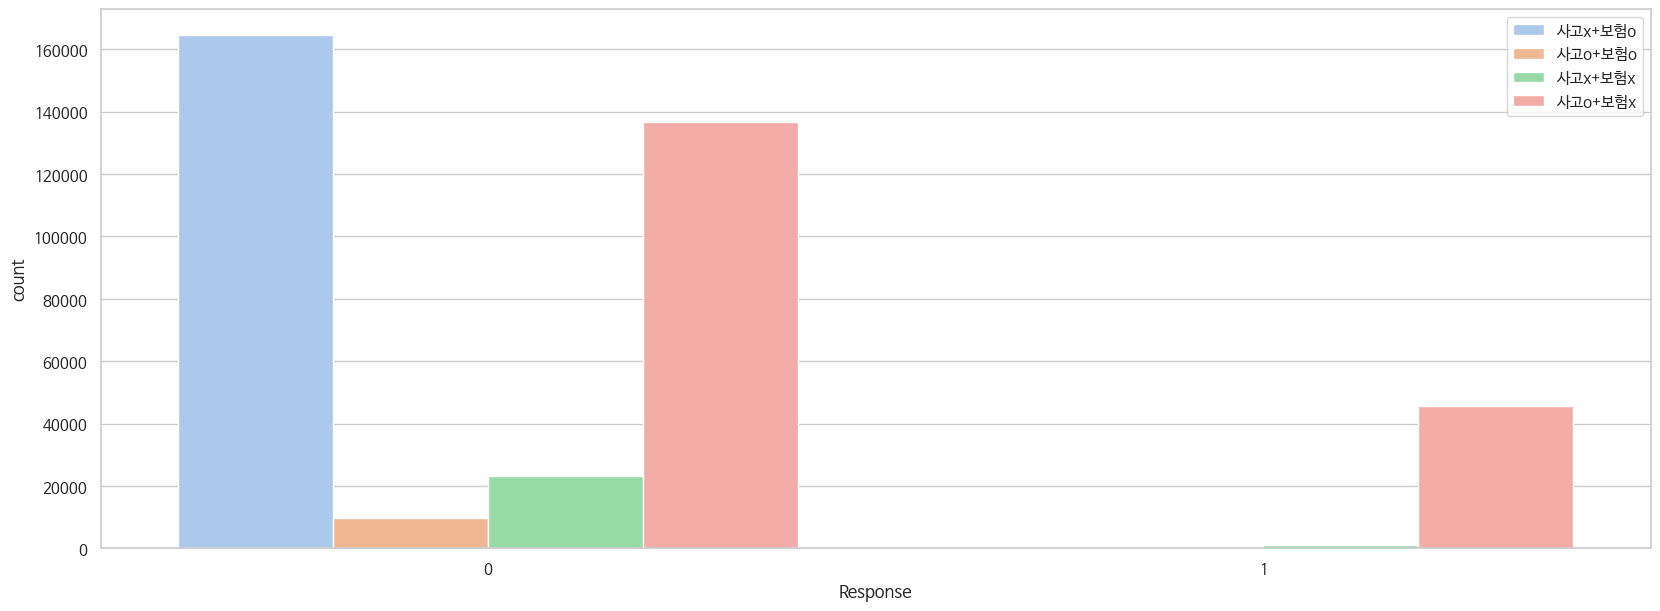

In [91]:
X_data['VD_PI'] = np.where((df['Vehicle_Damage_Label_En'] == 0) & (df['Previously_Insured'] == 1), 0,
                             np.where((df['Vehicle_Damage_Label_En'] == 1) & (df['Previously_Insured'] == 1), 1,
                                      np.where((df['Vehicle_Damage_Label_En'] == 0) & (df['Previously_Insured'] == 0), 2,
                                               np.where((df['Vehicle_Damage_Label_En'] == 1) & (df['Previously_Insured'] == 0), 3, -1))))
fig, ax = plt.subplots(figsize=(20,7))
sns.countplot(x=y, hue=X_data['VD_PI'], data=X_data, ax=ax, palette="pastel");
plt.legend(labels = ['사고x+보험o', '사고o+보험o', '사고x+보험x', '사고o+보험x']);
plt.savefig('VD_PI')

# 모델링

기존데이터 vs SMOTE vs UnderSampler

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.2)

# X_data_ch = X_data[['Vehicle_Damage_Label_En', 'Previously_Insured', 'VA_PI', 'age_VD', 'age_PI']]
# X_train, X_test, y_train, y_test = train_test_split(X_data_ch,
#                                                     y,
#                                                     stratify=y,
#                                                     test_size = 0.2)

## 기본 데이터

In [93]:
ABC = AdaBoostClassifier(random_state=42)
ABC.fit(X_train, y_train)

# ▶ 예측
ABC_y_pred_train = ABC.predict(X_train)
ABC_y_pred_test = ABC.predict(X_test)


In [94]:
LGBM = LGBMClassifier(random_state=42)
LGBM.fit(X_train, y_train)

# ▶ 예측
LGBM_y_pred_train = LGBM.predict(X_train)
LGBM_y_pred_test = LGBM.predict(X_test)


[LightGBM] [Info] Number of positive: 37368, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968376
[LightGBM] [Info] Start training from score -1.968376


In [95]:
XGBC = XGBClassifier(random_state=42)
XGBC.fit(X_train, y_train)

# ▶ 예측
XGBC_y_pred_train = XGBC.predict(X_train)
XGBC_y_pred_test = XGBC.predict(X_test)


In [96]:
KN = KNeighborsClassifier()
KN.fit(X_train, y_train)

# ▶ 예측
KN_y_pred_train = KN.predict(X_train)
KN_y_pred_test = KN.predict(X_test)


In [97]:
MLP = MLPClassifier(random_state=42)
MLP.fit(X_train, y_train)

# ▶ 예측
MLP_y_pred_train = MLP.predict(X_train)
MLP_y_pred_test = MLP.predict(X_test)


In [98]:
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

# ▶ 예측
RF_y_pred_train = RF.predict(X_train)
RF_y_pred_test = RF.predict(X_test)


In [99]:
GB = GradientBoostingClassifier(random_state=42)
GB.fit(X_train, y_train)

# ▶ 예측
GB_y_pred_train = GB.predict(X_train)
GB_y_pred_test = GB.predict(X_test)


In [100]:
CAT_data = cb.Pool(data=X_train, label=y_train)

CAT = cb.CatBoostClassifier(random_state=42)
CAT.fit(CAT_data)

# ▶ 예측
CAT_y_pred_train = CAT.predict(X_train)
CAT_y_pred_test = CAT.predict(X_test)


Learning rate set to 0.118484
0:	learn: 0.5109007	total: 62.7ms	remaining: 1m 2s
1:	learn: 0.4089850	total: 134ms	remaining: 1m 6s
2:	learn: 0.3560155	total: 199ms	remaining: 1m 6s
3:	learn: 0.3268462	total: 261ms	remaining: 1m 5s
4:	learn: 0.3101856	total: 318ms	remaining: 1m 3s
5:	learn: 0.2987510	total: 414ms	remaining: 1m 8s
6:	learn: 0.2919911	total: 534ms	remaining: 1m 15s
7:	learn: 0.2862400	total: 672ms	remaining: 1m 23s
8:	learn: 0.2826709	total: 792ms	remaining: 1m 27s
9:	learn: 0.2799957	total: 912ms	remaining: 1m 30s
10:	learn: 0.2777560	total: 1.04s	remaining: 1m 33s
11:	learn: 0.2759757	total: 1.17s	remaining: 1m 36s
12:	learn: 0.2747359	total: 1.3s	remaining: 1m 38s
13:	learn: 0.2736532	total: 1.42s	remaining: 1m 40s
14:	learn: 0.2730004	total: 1.54s	remaining: 1m 41s
15:	learn: 0.2724458	total: 1.67s	remaining: 1m 42s
16:	learn: 0.2719618	total: 1.78s	remaining: 1m 42s
17:	learn: 0.2714052	total: 1.89s	remaining: 1m 43s
18:	learn: 0.2711177	total: 2.02s	remaining: 1m 44

### 모델 비교

In [101]:
precision = [precision_score(y_test, ABC_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_y_pred_test, pos_label=1),
             precision_score(y_test, KN_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_y_pred_test, pos_label=1),
             precision_score(y_test, RF_y_pred_test, pos_label=1),
             precision_score(y_test, GB_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_y_pred_test, pos_label=1)]


In [102]:
recall = [recall_score(y_test, ABC_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_y_pred_test, pos_label=1),
             recall_score(y_test, KN_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_y_pred_test, pos_label=1),
             recall_score(y_test, RF_y_pred_test, pos_label=1),
             recall_score(y_test, GB_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_y_pred_test, pos_label=1)]


In [103]:
f1_s = [f1_score(y_test, ABC_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_y_pred_test, pos_label=1),
             f1_score(y_test, KN_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_y_pred_test, pos_label=1),
             f1_score(y_test, RF_y_pred_test, pos_label=1),
             f1_score(y_test, GB_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_y_pred_test, pos_label=1)]

In [104]:
base_score_df = pd.DataFrame([precision, recall, f1_s],
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision', 'recall', 'f1_score'])

In [105]:
base_score_df = base_score_df.T
base_score_df

,precision,recall,f1_score
ABC,0.000000,0.000000,0.000000
LGBM,0.291667,0.001499,0.002982
XGBC,0.440000,0.024727,0.046823
KN,0.209062,0.056305,0.088716
MLP,0.231660,0.006423,0.012499
RF,0.334608,0.159281,0.215824
GB,0.500000,0.000214,0.000428
CAT,0.472995,0.030936,0.058073


In [106]:
base_score_df.to_csv("base_score_df.csv", mode='w')

## SMOTE

In [107]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (304887, 14) (304887,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (535038, 14) (535038,)
SMOTE 적용 후 값의 분포 :
 0    267519
1    267519
Name: Response, dtype: int64


In [108]:
ABC_over = AdaBoostClassifier(random_state=42)
ABC_over.fit(X_train_over, y_train_over)

# ▶ 예측
ABC_over_y_pred_train = ABC_over.predict(X_train_over)
ABC_over_y_pred_test = ABC_over.predict(X_test)


In [109]:
LGBM_over = LGBMClassifier(random_state=42)
LGBM_over.fit(X_train_over, y_train_over)

# ▶ 예측
LGBM_over_y_pred_train = LGBM_over.predict(X_train_over)
LGBM_over_y_pred_test = LGBM_over.predict(X_test)


[LightGBM] [Info] Number of positive: 267519, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 535038, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [110]:
XGBC_over = XGBClassifier(random_state=42)
XGBC_over.fit(X_train_over, y_train_over)

# ▶ 예측
XGBC_over_y_pred_train = XGBC_over.predict(X_train_over)
XGBC_over_y_pred_test = XGBC_over.predict(X_test)


In [111]:
KN_over = KNeighborsClassifier()
KN_over.fit(X_train_over, y_train_over)

# ▶ 예측
KN_over_y_pred_train = KN_over.predict(X_train_over)
KN_over_y_pred_test = KN_over.predict(X_test)


In [112]:
MLP_over = MLPClassifier(random_state=42)
MLP_over.fit(X_train_over, y_train_over)

# ▶ 예측
MLP_over_y_pred_train = MLP_over.predict(X_train_over)
MLP_over_y_pred_test = MLP_over.predict(X_test)


In [113]:
RF_over = RandomForestClassifier(random_state=42)
RF_over.fit(X_train_over, y_train_over)

# ▶ 예측
RF_over_y_pred_train = RF_over.predict(X_train_over)
RF_over_y_pred_test = RF_over.predict(X_test)


In [114]:
GB_over = GradientBoostingClassifier(random_state=42)
GB_over.fit(X_train_over, y_train_over)

# ▶ 예측
GB_over_y_pred_train = GB_over.predict(X_train_over)
GB_over_y_pred_test = GB_over.predict(X_test)


In [115]:
CAT_data = cb.Pool(data=X_train_over, label=y_train_over)

CAT_over = cb.CatBoostClassifier(random_state=42)
CAT_over.fit(CAT_data)

# ▶ 예측
CAT_over_y_pred_train = CAT_over.predict(X_train_over)
CAT_over_y_pred_test = CAT_over.predict(X_test)


Learning rate set to 0.150645
0:	learn: 0.5374949	total: 114ms	remaining: 1m 53s
1:	learn: 0.4699149	total: 228ms	remaining: 1m 53s
2:	learn: 0.4252978	total: 329ms	remaining: 1m 49s
3:	learn: 0.4033948	total: 438ms	remaining: 1m 49s
4:	learn: 0.3864500	total: 545ms	remaining: 1m 48s
5:	learn: 0.3753188	total: 648ms	remaining: 1m 47s
6:	learn: 0.3689966	total: 741ms	remaining: 1m 45s
7:	learn: 0.3613993	total: 856ms	remaining: 1m 46s
8:	learn: 0.3550379	total: 957ms	remaining: 1m 45s
9:	learn: 0.3494595	total: 1.07s	remaining: 1m 45s
10:	learn: 0.3469083	total: 1.17s	remaining: 1m 45s
11:	learn: 0.3450356	total: 1.27s	remaining: 1m 44s
12:	learn: 0.3425809	total: 1.42s	remaining: 1m 47s
13:	learn: 0.3410218	total: 1.56s	remaining: 1m 50s
14:	learn: 0.3388952	total: 1.76s	remaining: 1m 55s
15:	learn: 0.3377327	total: 1.96s	remaining: 2m
16:	learn: 0.3365329	total: 2.15s	remaining: 2m 4s
17:	learn: 0.3357776	total: 2.32s	remaining: 2m 6s
18:	learn: 0.3336612	total: 2.52s	remaining: 2m 10

### 모델 비교

In [116]:
precision_over = [precision_score(y_test, ABC_over_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             precision_score(y_test, KN_over_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_over_y_pred_test, pos_label=1),
             precision_score(y_test, RF_over_y_pred_test, pos_label=1),
             precision_score(y_test, GB_over_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [117]:
recall_over = [recall_score(y_test, ABC_over_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             recall_score(y_test, KN_over_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_over_y_pred_test, pos_label=1),
             recall_score(y_test, RF_over_y_pred_test, pos_label=1),
             recall_score(y_test, GB_over_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [118]:
f1_score_over = [f1_score(y_test, ABC_over_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_over_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_over_y_pred_test, pos_label=1),
             f1_score(y_test, KN_over_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_over_y_pred_test, pos_label=1),
             f1_score(y_test, RF_over_y_pred_test, pos_label=1),
             f1_score(y_test, GB_over_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_over_y_pred_test, pos_label=1)]

In [119]:
over_score_df = pd.DataFrame([precision_over, recall_over, f1_score_over],
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision_over', 'recall_over', 'f1_score_over'])

In [120]:
over_score_df = over_score_df.T
over_score_df

,precision_over,recall_over,f1_score_over
ABC,0.298856,0.696211,0.418196
LGBM,0.315994,0.626204,0.420032
XGBC,0.318908,0.597945,0.415965
KN,0.180156,0.467245,0.260046
MLP,0.242710,0.869621,0.379502
RF,0.313247,0.471312,0.376357
GB,0.309211,0.674160,0.423965
CAT,0.321694,0.582852,0.414573


In [121]:
over_score_df.to_csv("over_score_df.csv", mode='w')

## RandomUnderSampler

In [122]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [123]:
ABC_under = AdaBoostClassifier(random_state=42)
ABC_under.fit(X_under, y_under)

# ▶ 예측
ABC_under_y_pred_train = ABC_under.predict(X_under)
ABC_under_y_pred_test = ABC_under.predict(X_test)

In [124]:
LGBM_under = LGBMClassifier(random_state=42)
LGBM_under.fit(X_under, y_under)

# ▶ 예측
LGBM_under_y_pred_train = LGBM_under.predict(X_under)
LGBM_under_y_pred_test = LGBM_under.predict(X_test)

[LightGBM] [Info] Number of positive: 37368, number of negative: 37368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 74736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [125]:
XGBC_under = XGBClassifier(random_state=42)
XGBC_under.fit(X_under, y_under)

# ▶ 예측
XGBC_under_y_pred_train = XGBC_under.predict(X_under)
XGBC_under_y_pred_test = XGBC_under.predict(X_test)

In [126]:
KN_under = KNeighborsClassifier()
KN_under.fit(X_under, y_under)

# ▶ 예측
KN_under_y_pred_train = KN_under.predict(X_under)
KN_under_y_pred_test = KN_under.predict(X_test)

In [127]:
MLP_under = MLPClassifier(random_state=42)
MLP_under.fit(X_under, y_under)

# ▶ 예측
MLP_under_y_pred_train = MLP_under.predict(X_under)
MLP_under_y_pred_test = MLP_under.predict(X_test)

In [128]:
RF_under = RandomForestClassifier(random_state=42)
RF_under.fit(X_under, y_under)

# ▶ 예측
RF_under_y_pred_train = RF_under.predict(X_under)
RF_under_y_pred_test = RF_under.predict(X_test)

In [129]:
GB_under = GradientBoostingClassifier(random_state=42)
GB_under.fit(X_under, y_under)

# ▶ 예측
GB_under_y_pred_train = GB_under.predict(X_under)
GB_under_y_pred_test = GB_under.predict(X_test)

In [130]:
CAT_under_data = cb.Pool(data=X_under, label=y_under)

CAT_under = cb.CatBoostClassifier(random_state=42)
CAT_under.fit(CAT_under_data)

# ▶ 예측
CAT_under_y_pred_train = CAT_under.predict(X_under)
CAT_under_y_pred_test = CAT_under.predict(X_test)

Learning rate set to 0.065003
0:	learn: 0.6388204	total: 17ms	remaining: 17s
1:	learn: 0.6032561	total: 30.3ms	remaining: 15.1s
2:	learn: 0.5714625	total: 46.9ms	remaining: 15.6s
3:	learn: 0.5460150	total: 64.1ms	remaining: 16s
4:	learn: 0.5283648	total: 80.6ms	remaining: 16s
5:	learn: 0.5107946	total: 96.2ms	remaining: 15.9s
6:	learn: 0.5010540	total: 113ms	remaining: 16s
7:	learn: 0.4914321	total: 130ms	remaining: 16.1s
8:	learn: 0.4842742	total: 147ms	remaining: 16.2s
9:	learn: 0.4753652	total: 165ms	remaining: 16.3s
10:	learn: 0.4684966	total: 182ms	remaining: 16.3s
11:	learn: 0.4642412	total: 201ms	remaining: 16.5s
12:	learn: 0.4608651	total: 217ms	remaining: 16.5s
13:	learn: 0.4569826	total: 234ms	remaining: 16.5s
14:	learn: 0.4546004	total: 250ms	remaining: 16.4s
15:	learn: 0.4519818	total: 268ms	remaining: 16.5s
16:	learn: 0.4495941	total: 282ms	remaining: 16.3s
17:	learn: 0.4470266	total: 299ms	remaining: 16.3s
18:	learn: 0.4447905	total: 316ms	remaining: 16.3s
19:	learn: 0.44

### 모델 비교

In [131]:
precision_under = [precision_score(y_test, ABC_under_y_pred_test, pos_label=1),
             precision_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             precision_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             precision_score(y_test, KN_under_y_pred_test, pos_label=1),
             precision_score(y_test, MLP_under_y_pred_test, pos_label=1),
             precision_score(y_test, RF_under_y_pred_test, pos_label=1),
             precision_score(y_test, GB_under_y_pred_test, pos_label=1),
             precision_score(y_test, CAT_under_y_pred_test, pos_label=1)]
recall_under = [recall_score(y_test, ABC_under_y_pred_test, pos_label=1),
             recall_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             recall_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             recall_score(y_test, KN_under_y_pred_test, pos_label=1),
             recall_score(y_test, MLP_under_y_pred_test, pos_label=1),
             recall_score(y_test, RF_under_y_pred_test, pos_label=1),
             recall_score(y_test, GB_under_y_pred_test, pos_label=1),
             recall_score(y_test, CAT_under_y_pred_test, pos_label=1)]
f1_score_under = [f1_score(y_test, ABC_under_y_pred_test, pos_label=1),
             f1_score(y_test, LGBM_under_y_pred_test, pos_label=1),
             f1_score(y_test, XGBC_under_y_pred_test, pos_label=1),
             f1_score(y_test, KN_under_y_pred_test, pos_label=1),
             f1_score(y_test, MLP_under_y_pred_test, pos_label=1),
             f1_score(y_test, RF_under_y_pred_test, pos_label=1),
             f1_score(y_test, GB_under_y_pred_test, pos_label=1),
             f1_score(y_test, CAT_under_y_pred_test, pos_label=1)]

In [132]:
under_score_df = pd.DataFrame([precision_under, recall_under, f1_score_under],
                        columns=['ABC', 'LGBM', 'XGBC', 'KN', 'MLP', 'RF', 'GB', 'CAT'],
                        index=['precision_under', 'recall_under', 'f1_score_under'])

In [133]:
under_score_df = under_score_df.T
under_score_df

,precision_under,recall_under,f1_score_under
ABC,0.274528,0.936309,0.424570
LGBM,0.276820,0.938022,0.427484
XGBC,0.278071,0.924641,0.427560
KN,0.168610,0.622351,0.265334
MLP,0.244989,0.011775,0.022470
RF,0.276325,0.846072,0.416592
GB,0.274487,0.939842,0.424883
CAT,0.278202,0.931064,0.428399


In [134]:
under_score_df.to_csv("under_score_df.csv", mode='w')

# 모델 고르기

In [135]:
scores_df = pd.concat([base_score_df, over_score_df, under_score_df], axis=1)
# over_score_df
# under_score_df
scores_df.to_csv("scores_df.csv", mode='w')

In [136]:
scores_df

,precision,recall,f1_score,precision_over,recall_over,f1_score_over,precision_under,recall_under,f1_score_under
ABC,0.000000,0.000000,0.000000,0.298856,0.696211,0.418196,0.274528,0.936309,0.424570
LGBM,0.291667,0.001499,0.002982,0.315994,0.626204,0.420032,0.276820,0.938022,0.427484
XGBC,0.440000,0.024727,0.046823,0.318908,0.597945,0.415965,0.278071,0.924641,0.427560
KN,0.209062,0.056305,0.088716,0.180156,0.467245,0.260046,0.168610,0.622351,0.265334
MLP,0.231660,0.006423,0.012499,0.242710,0.869621,0.379502,0.244989,0.011775,0.022470
RF,0.334608,0.159281,0.215824,0.313247,0.471312,0.376357,0.276325,0.846072,0.416592
GB,0.500000,0.000214,0.000428,0.309211,0.674160,0.423965,0.274487,0.939842,0.424883
CAT,0.472995,0.030936,0.058073,0.321694,0.582852,0.414573,0.278202,0.931064,0.428399


# scores

In [137]:
scores_df = pd.read_csv('/content/scores_df.csv', index_col ='Unnamed: 0')
scores_df

,precision,recall,f1_score,precision_over,recall_over,f1_score_over,precision_under,recall_under,f1_score_under
ABC,0.000000,0.000000,0.000000,0.298856,0.696211,0.418196,0.274528,0.936309,0.424570
LGBM,0.291667,0.001499,0.002982,0.315994,0.626204,0.420032,0.276820,0.938022,0.427484
XGBC,0.440000,0.024727,0.046823,0.318908,0.597945,0.415965,0.278071,0.924641,0.427560
KN,0.209062,0.056305,0.088716,0.180156,0.467245,0.260046,0.168610,0.622351,0.265334
MLP,0.231660,0.006423,0.012499,0.242710,0.869621,0.379502,0.244989,0.011775,0.022470
RF,0.334608,0.159281,0.215824,0.313247,0.471312,0.376357,0.276325,0.846072,0.416592
GB,0.500000,0.000214,0.000428,0.309211,0.674160,0.423965,0.274487,0.939842,0.424883
CAT,0.472995,0.030936,0.058073,0.321694,0.582852,0.414573,0.278202,0.931064,0.428399


In [138]:
precisions = scores_df[['precision', 'precision_over', 'precision_under']]
recalls = scores_df[['recall', 'recall_over', 'recall_under']]
f1_scores = scores_df[['f1_score', 'f1_score_over', 'f1_score_under']]

# cv

### grid cv

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm

hps = [
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'max_depth': [None, 3, 4, 5], }
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'loss': ["deviance"],
         'n_estimators': [100],
         'learning_rate': [0.1, 0.05, 0.01],
         'max_depth': [4],
         'min_samples_leaf': [100, 150],
         'max_features': [0.3, 0.1]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
         'max_depth': [None, 3, 4, 5]}
    )
]

for hp, param_grid in tqdm(hps):
    grid_search = GridSearchCV(hp, param_grid, scoring='roc_auc',
                               cv=5, n_jobs=-1)
    grid_search.fit(X_under, y_under)
    hp_name = type(hp).__name__
    hp_score = grid_search.score(X_test, y_test)
    print('최적 하이퍼 파라미터: ', grid_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(grid_search.best_score_))

 33%|███▎      | 1/3 [06:07<12:14, 367.12s/it]

최적 하이퍼 파라미터:  {'max_depth': 5, 'n_estimators': 300}
최고 예측 정확도: 0.8427


 67%|██████▋   | 2/3 [08:29<03:55, 235.14s/it]

최적 하이퍼 파라미터:  {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 150, 'n_estimators': 100}
최고 예측 정확도: 0.8498
[LightGBM] [Info] Number of positive: 37368, number of negative: 37368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 74736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

100%|██████████| 3/3 [11:32<00:00, 230.87s/it]

최적 하이퍼 파라미터:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
최고 예측 정확도: 0.8508


### random cv

In [140]:
hps = [
    (
        XGBClassifier(random_state=0),
        {'min_child_weight' : [1, 3, 5],
         'n_estimators' : [250, 300, 350],
         'learning_rate': [1, 0.1, 0.01],
         'max_depth': [None,3,4,5],
         'reg_alpha': [0, 0.01, 0.001]}
    ),
    (
        cb.CatBoostClassifier(random_state=0),
        {
         'learning_rate': [0.1, 0.2, 0.3],
         'max_depth': [5, 7, 9],
         'l2_leaf_reg': [1, 3, 5, 7, 9],
         'random_strength': [1, 10, 100]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'n_estimators': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
          'max_depth': [None,3,4,5]}
    )

]
for hp, param_grid in tqdm(hps):
    rand_search = RandomizedSearchCV(hp, param_grid, n_iter=5, scoring='roc_auc',
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_under, y_under)
    hp_name = type(hp).__name__
    hp_score = rand_search.score(X_test, y_test)
    print('최적 하이퍼 파라미터: ', rand_search.best_params_)
    print('최고 예측 정확도: {:.4f}'.format(rand_search.best_score_))

 33%|███▎      | 1/3 [00:28<00:56, 28.22s/it]

최적 하이퍼 파라미터:  {'reg_alpha': 0.001, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}
최고 예측 정확도: 0.8505
0:	learn: 0.6194079	total: 15.1ms	remaining: 15.1s
1:	learn: 0.5707320	total: 28ms	remaining: 14s
2:	learn: 0.5533710	total: 43.1ms	remaining: 14.3s
3:	learn: 0.5307984	total: 56.9ms	remaining: 14.2s
4:	learn: 0.5051555	total: 71.4ms	remaining: 14.2s
5:	learn: 0.4914375	total: 83.5ms	remaining: 13.8s
6:	learn: 0.4802678	total: 98.3ms	remaining: 13.9s
7:	learn: 0.4707830	total: 113ms	remaining: 14s
8:	learn: 0.4649744	total: 128ms	remaining: 14s
9:	learn: 0.4598172	total: 142ms	remaining: 14.1s
10:	learn: 0.4558845	total: 155ms	remaining: 14s
11:	learn: 0.4538846	total: 166ms	remaining: 13.7s
12:	learn: 0.4521624	total: 181ms	remaining: 13.7s
13:	learn: 0.4502680	total: 192ms	remaining: 13.5s
14:	learn: 0.4493106	total: 205ms	remaining: 13.5s
15:	learn: 0.4477934	total: 223ms	remaining: 13.7s
16:	learn: 0.4470522	total: 237ms	remaining: 13.7s
17:	learn: 

 67%|██████▋   | 2/3 [05:11<02:58, 178.10s/it]

최적 하이퍼 파라미터:  {'random_strength': 100, 'max_depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 7}
최고 예측 정확도: 0.8473
[LightGBM] [Info] Number of positive: 37368, number of negative: 37368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 74736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

100%|██████████| 3/3 [05:27<00:00, 109.20s/it]

최적 하이퍼 파라미터:  {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
최고 예측 정확도: 0.8504


In [141]:
# 최적 하이퍼 파라미터:  {'reg_alpha': 0.001, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}
rand_XGBC_under = XGBClassifier(reg_alpha=0.001, n_estimators=300, min_child_weight=1, max_depth=3, learning_rate=0.1, random_state=42)
rand_XGBC_under.fit(X_under, y_under)

# ▶ 예측
rand_XGBC_under_y_pred_train = rand_XGBC_under.predict(X_under)
rand_XGBC_under_y_pred_test = rand_XGBC_under.predict(X_test)

In [142]:
# 최적 하이퍼 파라미터:  {'random_strength': 100, 'max_depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 7}
rand_CAT_under = cb.CatBoostClassifier(random_strength=100, max_depth=5, learning_rate=0.1, l2_leaf_reg=7, random_state=42)
rand_CAT_under.fit(CAT_under_data)

# ▶ 예측
rand_CAT_under_y_pred_train = rand_CAT_under.predict(X_under)
rand_CAT_under_y_pred_test = rand_CAT_under.predict(X_test)

0:	learn: 0.6149851	total: 15.2ms	remaining: 15.2s
1:	learn: 0.5687369	total: 31.4ms	remaining: 15.7s
2:	learn: 0.5352382	total: 48.2ms	remaining: 16s
3:	learn: 0.5108114	total: 63.3ms	remaining: 15.8s
4:	learn: 0.4976214	total: 76.2ms	remaining: 15.2s
5:	learn: 0.4872879	total: 90.1ms	remaining: 14.9s
6:	learn: 0.4802039	total: 105ms	remaining: 14.9s
7:	learn: 0.4725772	total: 119ms	remaining: 14.7s
8:	learn: 0.4666021	total: 131ms	remaining: 14.5s
9:	learn: 0.4657020	total: 142ms	remaining: 14s
10:	learn: 0.4614504	total: 155ms	remaining: 13.9s
11:	learn: 0.4579604	total: 169ms	remaining: 13.9s
12:	learn: 0.4555257	total: 179ms	remaining: 13.6s
13:	learn: 0.4544295	total: 194ms	remaining: 13.7s
14:	learn: 0.4537373	total: 207ms	remaining: 13.6s
15:	learn: 0.4515850	total: 223ms	remaining: 13.7s
16:	learn: 0.4489912	total: 237ms	remaining: 13.7s
17:	learn: 0.4477162	total: 251ms	remaining: 13.7s
18:	learn: 0.4466475	total: 266ms	remaining: 13.7s
19:	learn: 0.4458358	total: 292ms	remai

In [143]:
# 최적 하이퍼 파라미터:  {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
rand_LGBM = LGBMClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
rand_LGBM.fit(X_under, y_under)

# ▶ 예측
rand_LGBM_y_pred_train = rand_LGBM.predict(X_under)
rand_LGBM_y_pred_test = rand_LGBM.predict(X_test)

[LightGBM] [Info] Number of positive: 37368, number of negative: 37368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 74736, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

# 모델 고르기

만들어 둔 모델들의 precision	recall	f1_score 값을 비교하여 각각 가장 높은 성능을 보이는 모델을 선택

In [144]:
precision_hp = [
             precision_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             precision_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             precision_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]
recall_hp = [
             recall_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             recall_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             recall_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]
f1_score_hp = [
             f1_score(y_test, rand_XGBC_under_y_pred_test, pos_label=1),
             f1_score(y_test, rand_CAT_under_y_pred_test, pos_label=1),
             f1_score(y_test, rand_LGBM_y_pred_test, pos_label=1)]

In [145]:
hp_score_df = pd.DataFrame([precision_hp, recall_hp, f1_score_hp],
                        columns=['rand_XGBC', 'rand_CAT', 'rand_LGBM'],
                        index=['precision', 'recall', 'f1_score'])

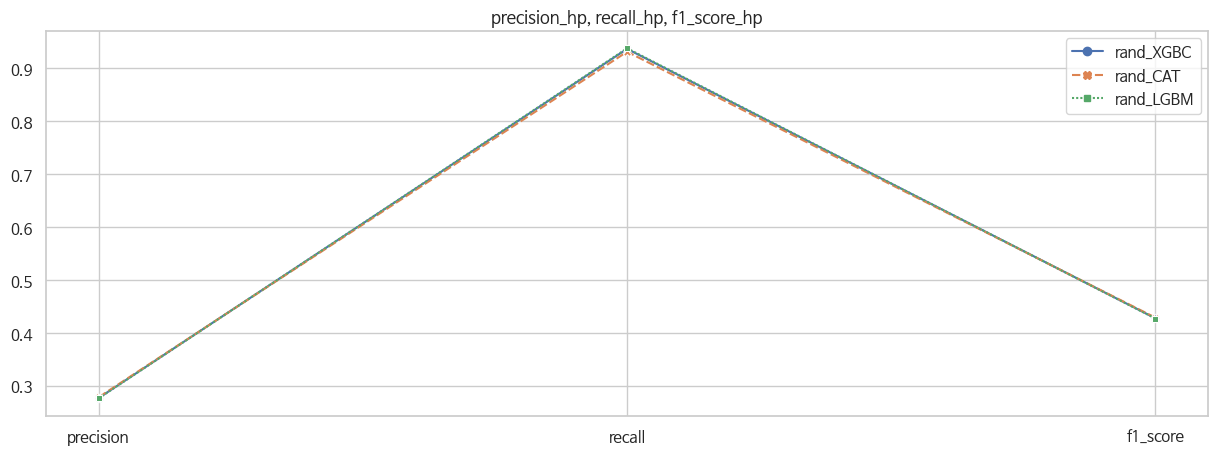

In [146]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = hp_score_df, markers=True).set(title='precision_hp, recall_hp, f1_score_hp');
plt.savefig('hp_score_df')

# feature importances

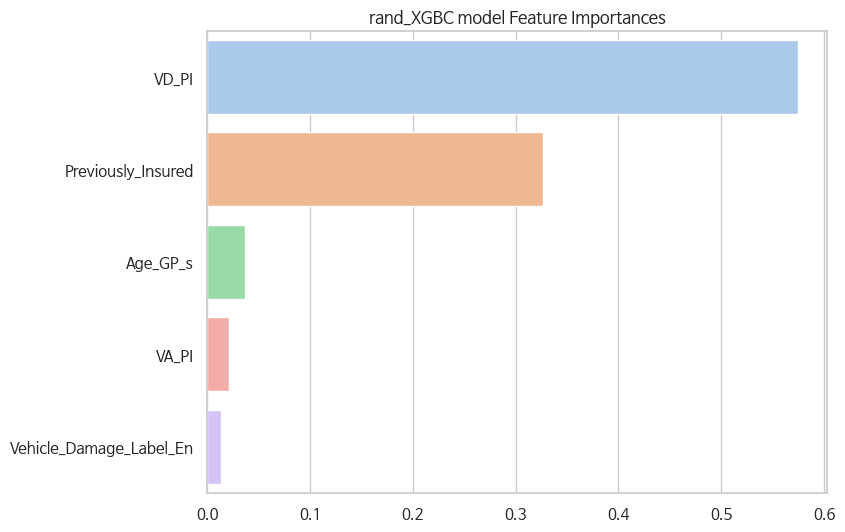

In [147]:
ftr_importances_values = rand_XGBC_under.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('rand_XGBC model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)


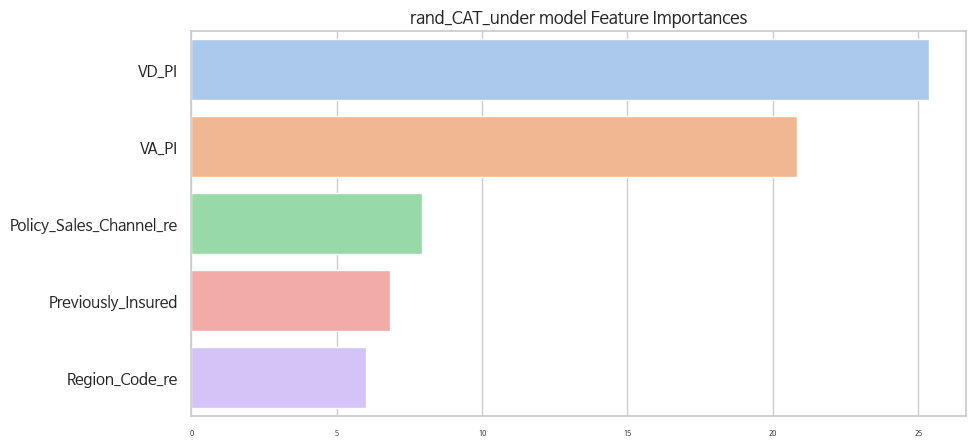

In [148]:
ftr_importances_values = rand_CAT_under.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(10,5))
plt.title('rand_CAT_under model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

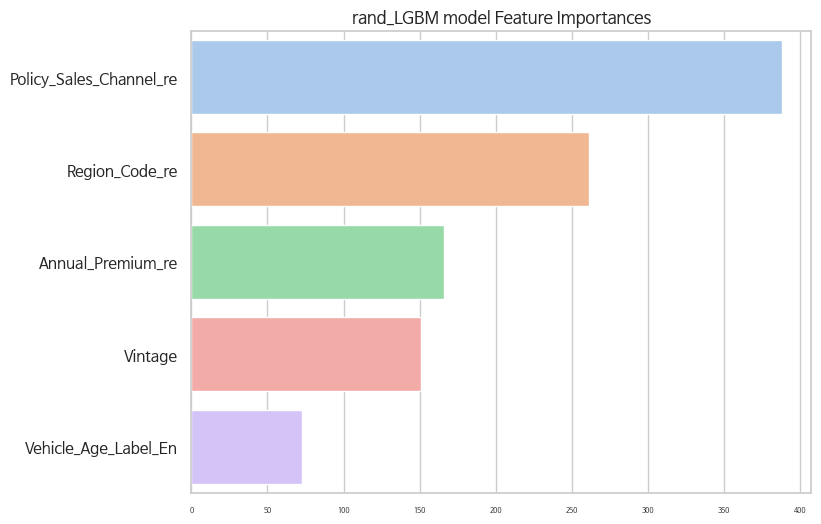

In [149]:
ftr_importances_values = rand_LGBM.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=(8,6))
plt.title('rand_LGBM model Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()

# 성능높이기

## 스케일링

하지 않은 데이터와 큰 차이 없음



In [150]:
#스탠다드 스케일러
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
scaled_X_train = X_scaler.fit_transform(X_under)
scaled_X_test = X_scaler.transform(X_test)
print(scaled_X_train.shape)
print(scaled_X_test.shape)

(74736, 14)
(76222, 14)


In [151]:
scaled_hy_RF = RandomForestClassifier(max_depth=5, n_estimators=300)
scaled_hy_RF.fit(scaled_X_train, y_under)

# ▶ 예측
scaled_hy_RF_y_pred_train = scaled_hy_RF.predict(scaled_X_train)
scaled_hy_RF_y_pred_test = scaled_hy_RF.predict(scaled_X_test)

print(classification_report(y_under, scaled_hy_RF_y_pred_train))
print(classification_report(y_test, scaled_hy_RF_y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.63      0.75     37368
           1       0.72      0.95      0.82     37368

    accuracy                           0.79     74736
   macro avg       0.83      0.79      0.79     74736
weighted avg       0.83      0.79      0.79     74736

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     66880
           1       0.27      0.95      0.42      9342

    accuracy                           0.67     76222
   macro avg       0.63      0.79      0.59     76222
weighted avg       0.90      0.67      0.73     76222



In [152]:
print(recall_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

0.9521515735388568


In [153]:
print(precision_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

0.26556202418271385


In [154]:
print(f1_score(y_test, scaled_hy_RF_y_pred_test, pos_label=1))

0.41529518873870713


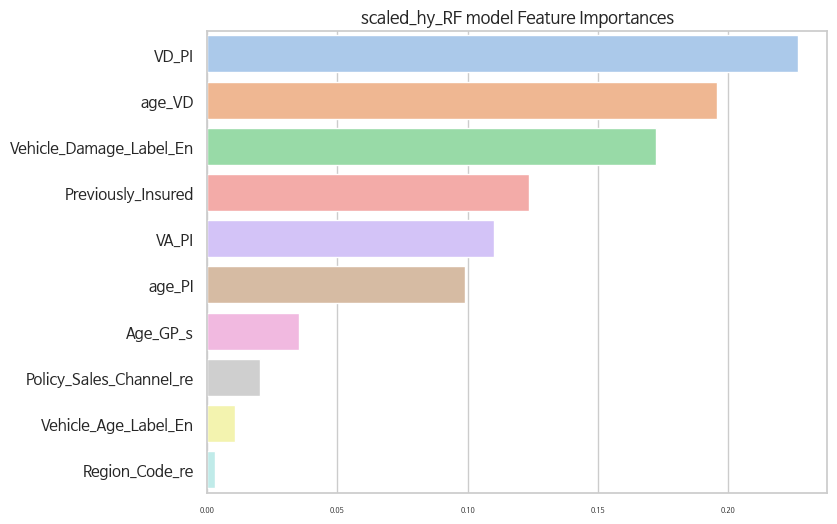

In [155]:
ftr_importances_values = scaled_hy_RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_under.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('scaled_hy_RF model Feature Importances')
sns.barplot(x=ftr_top10, y=ftr_top10.index, palette="pastel")
plt.rc('xtick', labelsize=5)
plt.show()